In [1]:
import pandas as pd
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import IPython.display as display
from matplotlib import animation
import torch
import copy
from torch import nn
%matplotlib inline
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class expermentDataloader(Dataset):
    def __init__(
        self,
        index_file: str, 
        data_path: str,
        startIndex = 0,
        endIndex = -1
    ):
        self.root_dir = data_path
        self.expermentSikeTrainsIndex = np.array(pd.read_csv(index_file,header=None))[startIndex:endIndex]
        self.spikeTrains = [
            f"{os.path.join(self.expermentSikeTrainsIndex[i][0])}" for i in range(len(self.expermentSikeTrainsIndex)) 
        ]
        self.targets = self.expermentSikeTrainsIndex[:, 1]

    def __getitem__(self, index):
        inputCSVlines = pd.read_csv(os.path.join(self.root_dir,self.spikeTrains[index])).to_numpy()
        targetCSVLines = self.targets[index]
        return inputCSVlines.flatten(), np.array([targetCSVLines])

    def __len__(self):
        return len(self.expermentSikeTrainsIndex)

In [3]:
from torch.utils.data import DataLoader
from sklearn import preprocessing 
batch_size = 10
datasetlow = expermentDataloader(
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/low/index.csv",
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/low", 
    startIndex=0, endIndex=70
)
datasetmedium = expermentDataloader(
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/medium/index.csv",
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/medium", 
    startIndex=0, endIndex=60)

datasetHigh = expermentDataloader(
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/high/index.csv",
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/high", 
    startIndex=0, endIndex=-1
)

print(f"datasetlow:{len(datasetlow)}")
print(f"datasetmedium:{len(datasetmedium)}")
print(f"datasetHigh:{len(datasetHigh)}")
def addData(trainData: list, testData: list, expermentDataset: expermentDataloader, cutoffIndex=None):
    cutoffIndex = int(len(expermentDataset)*0.9) if cutoffIndex == None else cutoffIndex
    for i in range(cutoffIndex):
        trainData.append(expermentDataset[i])
    for i in range(cutoffIndex, len(expermentDataset)):
        testData.append(expermentDataset[i])

rawData = []
addData(rawData, [], datasetlow, cutoffIndex=len(datasetlow))
addData(rawData, [], datasetmedium, cutoffIndex=len(datasetmedium))
addData(rawData, [], datasetHigh, cutoffIndex=len(datasetHigh))
rawData = [[k,v] for k,v in rawData]
magnetSettings = [1.5] * 27 # 1.5mm_35.14pN
magnetSettings += [2] * 28  # 2mm_22.6pN
magnetSettings += [3] * 16  # 3mm_9.24pN
magnetSettings += [5] * 63  # 5mm_1.46pN
magnetSettings += [9] * 21  # 9mm_0.002pN
magnetSettings = [[i] for i in magnetSettings]

forceSettings = [35.14] * 27  # 1.5mm_35.14pN
forceSettings += [22.6] * 28  # 2mm_22.6pN
forceSettings += [9.24] * 16  # 3mm_9.24pN
forceSettings += [1.46] * 63  # 5mm_1.46pN
forceSettings += [0.002] * 21 # 9mm_0.002pN
forceSettings = [[i] for i in forceSettings]

trains, targets = list(map(list, zip(*rawData)))
tmp = list(zip(trains,magnetSettings,forceSettings))
tmp = list(list(i[0]) + list(i[1]) + list(i[2]) for i in tmp)
rawData = (list(zip(tmp,targets)))
datasetlow = rawData[:len(datasetlow)]
datasetmedium = rawData[len(datasetlow):len(datasetlow)+len(datasetmedium)]
datasetHigh = rawData[len(datasetlow)+len(datasetmedium):]
trainData = []
testData = []
validData = []

addData(trainData, testData, datasetlow, cutoffIndex=int(len(datasetlow)*0.8))
addData(trainData, testData, datasetmedium, cutoffIndex=int(len(datasetmedium)*0.8))
addData(trainData, testData, datasetHigh, cutoffIndex=int(len(datasetHigh)*0.8))

trainData = [([np.array(i).flatten(), np.array(t)]) for i,t in trainData]
testData = [([np.array(i).flatten(), np.array(t)]) for i,t in testData]

trainDataset = DataLoader(trainData, batch_size=batch_size, shuffle=True)
testDataset = DataLoader(testData, batch_size=batch_size, shuffle=True)
print(f"Training dataset size: {len(trainData)}")
print(f"Testing dataset size: {len(testData)}")
print(f"number train batches:{len(trainDataset)}")
print(f"number test batches:{len(testDataset)}")
featIn = len(trainData[0][0])

datasetlow:56
datasetmedium:16
datasetHigh:83
Training dataset size: 122
Testing dataset size: 33
number train batches:13
number test batches:4


In [22]:
int(len(datasetHigh)*0.8)

66

In [4]:
model = nn.Sequential(
          nn.Linear(featIn,16000),
          nn.ReLU(),
          nn.Linear(16000,16000),
          nn.ReLU(),
          nn.Linear(16000,16000),
          nn.ReLU(),
          nn.Linear(16000,16000),
          nn.ReLU(),
          nn.Linear(16000,1),
        )
PATH = "Models/11.04.2023_01-35-11-455530.pt"
model.load_state_dict(torch.load(PATH))
model.to(device)
model.eval()

Sequential(
  (0): Linear(in_features=12001, out_features=16000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16000, out_features=16000, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16000, out_features=16000, bias=True)
  (5): ReLU()
  (6): Linear(in_features=16000, out_features=16000, bias=True)
  (7): ReLU()
  (8): Linear(in_features=16000, out_features=1, bias=True)
)

#### High
----

In [5]:
testHigh = [i for i in testData if i[0][-2] in [9.0, 5.0]]
testDatasetHigh = DataLoader(testHigh, batch_size=len(testHigh), shuffle=True)
testHigh

[[array([0.  , 0.  , 0.  , ..., 0.  , 5.  , 1.46]), array([20])],
 [array([0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 9.e+00, 2.e-03]), array([363])],
 [array([0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 9.e+00, 2.e-03]), array([243])],
 [array([0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 9.e+00, 2.e-03]), array([375])],
 [array([0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 9.e+00, 2.e-03]), array([413])],
 [array([0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 9.e+00, 2.e-03]), array([210])],
 [array([0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 9.e+00, 2.e-03]), array([155])],
 [array([0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 9.e+00, 2.e-03]), array([342])],
 [array([0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 9.e+00, 2.e-03]), array([252])],
 [array([0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 9.e+00, 2.e-03]), array([55])],
 [array([0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 9.e+00, 2.e-03]), array([234])],
 [array([0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 9.e+00, 2.e-03]), array([336])],
 [array([0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 9.e+00, 2.e-03]), ar

In [6]:
len(testHigh)

18

In [30]:
em =52
epochs = 100
accs = []
print("test...")
for e in range(epochs): 
    avgLoss = []
    currentAcc = []
    for i, (inputs, targets) in enumerate(testDatasetHigh):
        inputs, targets= inputs.float().to(device), targets.float().to(device)
        outputs = model(inputs)
        outputPlot = outputs.clone().detach().cpu().numpy()
        targetsPlot = targets.clone().detach().cpu().numpy()
        totalCorrect = torch.sum(torch.isclose(outputs.int(), targets.int(), atol=em))
        totalCorrect = totalCorrect.clone().detach().cpu().numpy()
        currentAcc.append(float(totalCorrect/len(targets)))
        accs.append(float(totalCorrect/len(targets)))

print(f"\
    accuracy:{np.sum(accs)/len(accs)} \
    ",end="\x1b\r")

test...


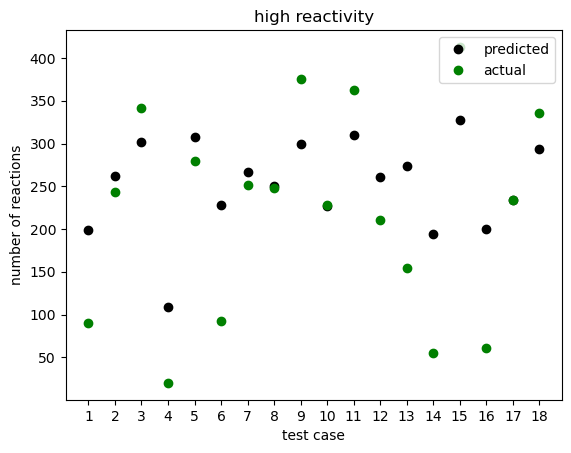

In [8]:
x_marks = [i + 1 for i in list(range(len(outputPlot)))]
plt.plot(x_marks, outputPlot, 'o', color='black', label="predicted")
plt.plot(x_marks, targetsPlot, 'o', color='green', label="actual")
plt.xticks(ticks=x_marks, labels=x_marks)
plt.xlabel('test case')
plt.ylabel('number of reactions')
plt.title('high reactivity')
plt.legend(loc='upper right')

#### medium
----

In [9]:
testmedium = [i for i in testData if i[0][-2] in [3.0]]
testDatasetmedium = DataLoader(testmedium, batch_size=len(testmedium), shuffle=True)
testmedium

[[array([0.  , 0.  , 0.  , ..., 0.  , 3.  , 9.24]), array([26])],
 [array([0.  , 0.  , 0.  , ..., 0.  , 3.  , 9.24]), array([153])],
 [array([0.  , 0.  , 0.  , ..., 0.  , 3.  , 9.24]), array([93])],
 [array([0.  , 0.  , 0.  , ..., 0.  , 3.  , 9.24]), array([132])]]

In [39]:

em =40
epochs = 100
accs = []
print("test...")
for e in range(epochs): 
    
    avgLoss = []
    currentAcc = []
    for i, (inputs, targets) in enumerate(testDatasetmedium):
        inputs, targets= inputs.float().to(device), targets.float().to(device)
        outputs = model(inputs)
        outputPlot = outputs.clone().detach().cpu().numpy()
        targetsPlot = targets.clone().detach().cpu().numpy()
        totalCorrect = torch.sum(torch.isclose(outputs.int(), targets.int(), atol=em))
        totalCorrect = totalCorrect.clone().detach().cpu().numpy()
        currentAcc.append(float(totalCorrect/len(targets)))
        accs.append(float(totalCorrect/len(targets)))

print(f"\
    accuracy:{np.sum(accs)/len(accs)} \
    ",end="\x1b\r")

test...


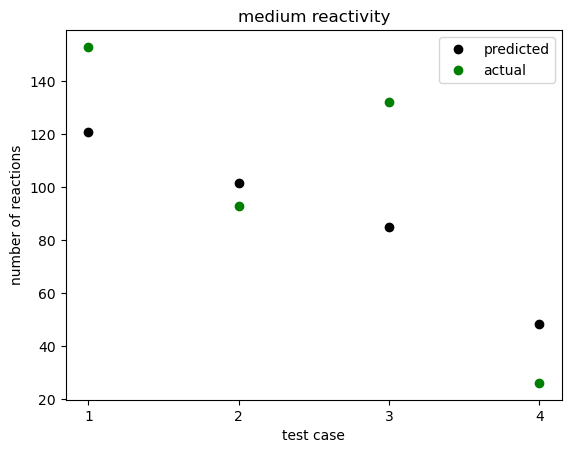

In [25]:
x_marks = [i + 1 for i in list(range(len(outputPlot)))]
plt.plot(x_marks, outputPlot, 'o', color='black', label="predicted")
plt.plot(x_marks, targetsPlot, 'o', color='green', label="actual")
plt.xticks(ticks=x_marks, labels=x_marks)
plt.xlabel('test case')
plt.ylabel('number of reactions')
plt.title('medium reactivity')
plt.legend(loc='upper right')

#### low
----

In [12]:

testLow = [i for i in testData if i[0][-2] in [2.0,1.5]]
testDatasetLow = DataLoader(testLow, batch_size=len(testLow), shuffle=True)
len(testLow)

11

In [56]:

em =12
epochs = 100
accs = []
print("test...")
for e in range(epochs): 
    avgLoss = []
    currentAcc = []
    for i, (inputs, targets) in enumerate(testDatasetLow):
        inputs, targets= inputs.float().to(device), targets.float().to(device)
        outputs = model(inputs)
        outputPlot = outputs.clone().detach().cpu().numpy()
        targetsPlot = targets.clone().detach().cpu().numpy()
        totalCorrect = torch.sum(torch.isclose(outputs.int(), targets.int(), atol=em))
        totalCorrect = totalCorrect.clone().detach().cpu().numpy()
        currentAcc.append(float(totalCorrect/len(targets)))
        accs.append(float(totalCorrect/len(targets)))

print(f"\
    accuracy:{np.sum(accs)/len(accs)} \
    ",end="\x1b\r")

test...


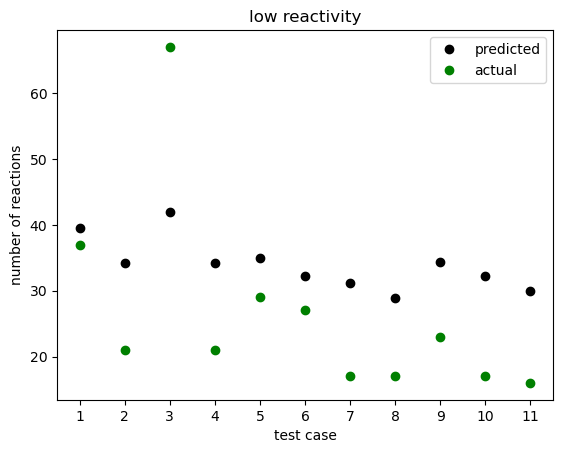

In [14]:
x_marks = [i + 1 for i in list(range(len(outputPlot)))]
plt.plot(x_marks, outputPlot, 'o', color='black', label="predicted")
plt.plot(x_marks, targetsPlot, 'o', color='green', label="actual")
plt.xticks(ticks=x_marks, labels=x_marks)
plt.xlabel('test case')
plt.ylabel('number of reactions')
plt.title('low reactivity')
plt.legend(loc='upper right')